#### Dependencies

In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os
path_base="/content/drive/MyDrive/Capstone"
path_LSTM ="/content/drive/MyDrive/Capstone/Model/LSTM"
output_path = '/content/drive/MyDrive/Capstone/Model/LSTM/output/'
result_path = '/content/drive/MyDrive/Capstone/Model/LSTM/result/'
os.chdir(path_base)
os.chdir(path_LSTM)
os.chdir(output_path)
os.chdir(result_path)

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Capstone/Model/LSTM
from Helpers import *
from LSTM_Helpers import *

/content/drive/MyDrive/Capstone/Model/LSTM


#### Data

use `rolling_statistics` as the imputation method

In [6]:
path="/content/drive/MyDrive/Capstone/Data/cleaned/"
os.chdir(path)
Data_dic_m = pd.ExcelFile('Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('Service_filled.xlsx')

In [7]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    if sheet[3:].strip() == 'Rolling statistics':
        m_dfs[sheet[:3]] = df

In [8]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    if sheet[3:].strip() == 'Rolling statistics':
      s_dfs[sheet[:3]] = df

#### Pipeline

###### Hypers

In [9]:
SHIFT = 5
LW = 5
IW = 4
MAX_EPOCHS = 200
bs = 8
verbose = True
lr = 0.001
patience = 100
LOSS = tf.keras.losses.MeanAbsoluteError()

In [10]:
cmap = sns.color_palette('muted', 6).as_hex()[:]
cmap.append('#17becf')
sns.set_style("whitegrid")

##### 1-Manufacturing

In [74]:
target_type = 'Manufacturing'

###### Multivariate

In [75]:
model_type = 'Multivariate'

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1793 - val_loss: 0.3726
Epoch 2/200
1/1 [==============================] - 0s 61ms/step - loss: 0.1357 - val_loss: 0.3718
Epoch 3/200
1/1 [==============================] - 0s 51ms/step - loss: 0.1047 - val_loss: 0.3721
Epoch 4/200
1/1 [==============================] - 0s 55ms/step - loss: 0.1008 - val_loss: 0.3713
Epoch 5/200
1/1 [==============================] - 0s 69ms/step - loss: 0.1112 - val_loss: 0.3689
Epoch 6/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0903 - val_loss: 0.3672
Epoch 7/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0837 - val_loss: 0.3664
Epoch 8/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0834 - val_loss: 0.3660
Epoch 9/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0798 - val_loss: 0.3651
Epoch 10/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0819 - val_loss: 0.3631
Epoch 11/200
1/1 [===

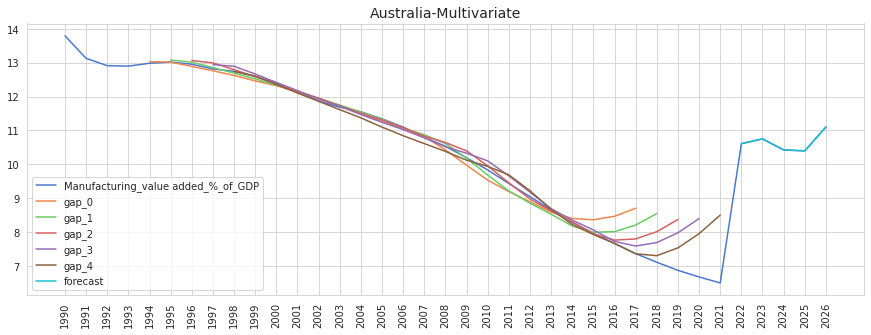

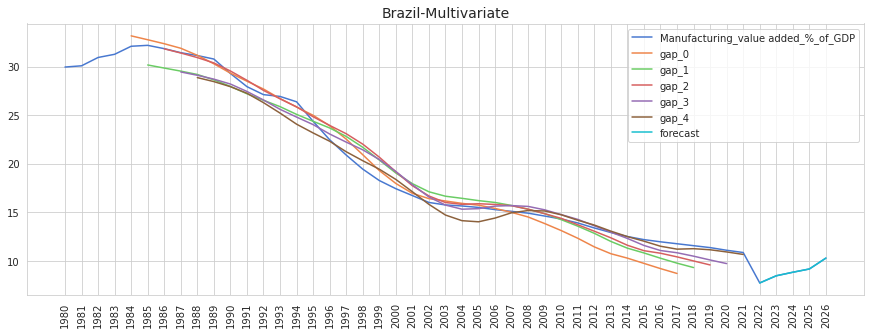

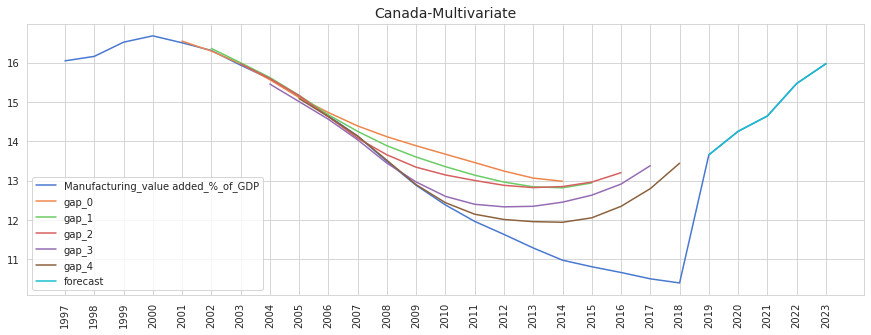

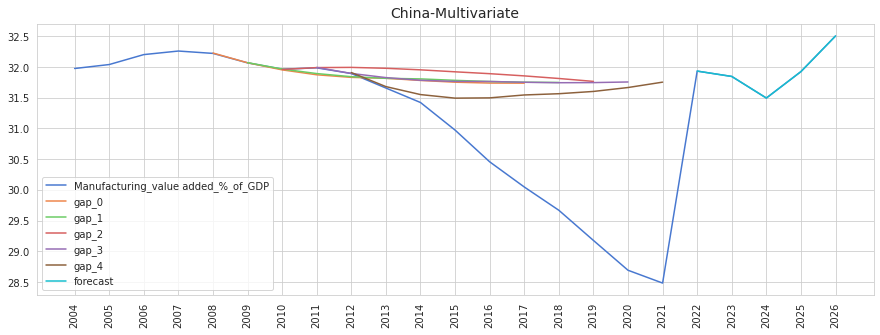

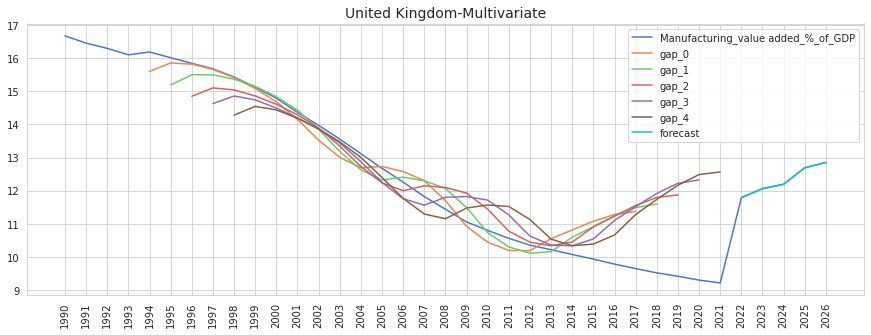

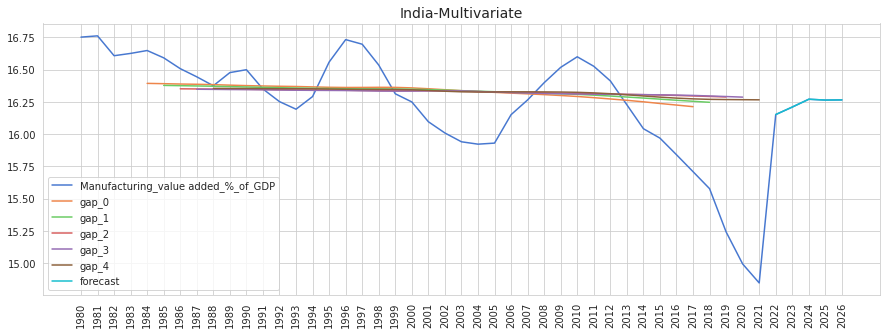

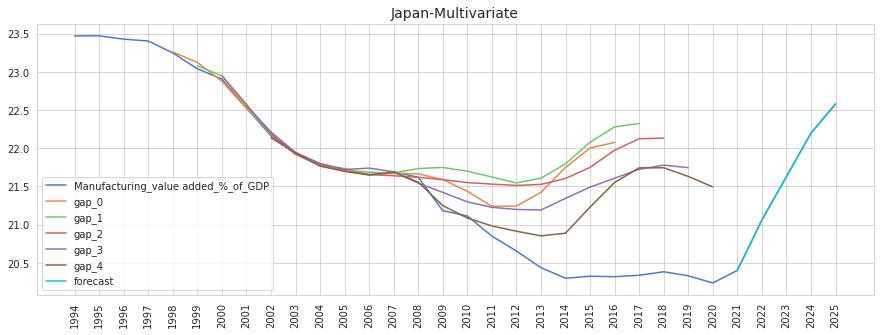

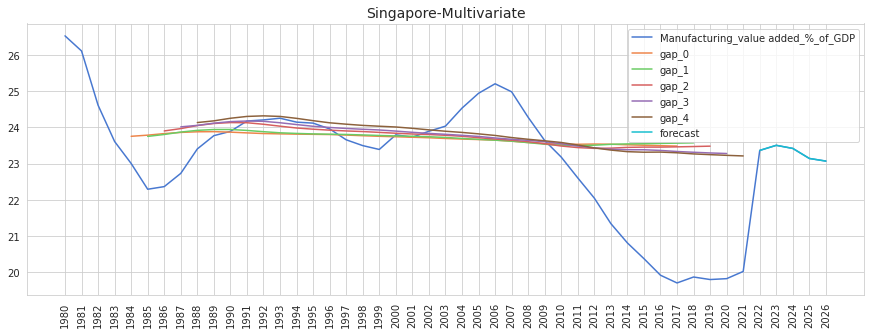

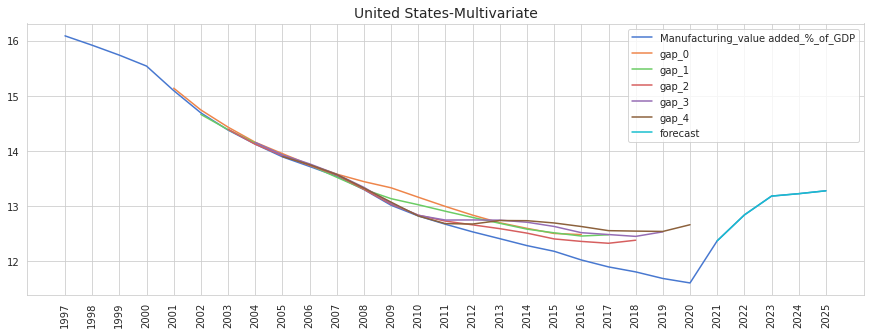

In [76]:
MAEs, RMSEs, MAPEs = [], [], []
for ckey in m_dfs.keys():
  country = dic_country[ckey]
  data = m_dfs[ckey]
  rbscaler = MRobustScaler() 
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  # use 4 year to predict 1 year ahead
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1],
  '\nMAPE', list(MAPE(y_pred, y_real)), 'Mean RMSE', MAPE(y_pred, y_real)[1],
  )
  MAEs.append(str(round(min(MAE(y_pred, y_real)[0]), 2)) + '-' + str(round(max(MAE(y_pred, y_real)[0]),2)))
  RMSEs.append(str(round(min(RMSE(y_pred, y_real)[0]), 2)) + '-' + str(round(max(RMSE(y_pred, y_real)[0]),2)))
  MAPEs.append(str(round(min(MAPE(y_pred, y_real)), 2)) + '-' + str(round(max(MAPE(y_pred, y_real)),2)))
  y_pred, y_real = fetch_all_pred_real(rbscaler, model)
  fcst = forecast(rbscaler, scaled_data, model, IW=IW)
  fcst['forecast'] = fcst['Manufacturing_value added_%_of_GDP']
  df = pd.concat(
    [pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1),
    fcst
    ]
  )
  fig = plt.figure(figsize = (15, 5))
  ax = fig.add_subplot(1, 1, 1)
  ax = df.plot(color = cmap, ax=ax)
  plt.title(f'{country}-{model_type}', fontsize=14)
  plt.xticks(rotation=90)
  t = ax.set_xticks(list(df.index))
  ax.get_figure().savefig(output_path + target_type +f'/{country}-{model_type}', bbox_inches='tight')

###### Univariate

In [77]:
model_type = 'Univariate'

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1804 - val_loss: 0.3769
Epoch 2/200
1/1 [==============================] - 0s 49ms/step - loss: 0.1624 - val_loss: 0.3845
Epoch 3/200
1/1 [==============================] - 0s 51ms/step - loss: 0.1449 - val_loss: 0.3951
Epoch 4/200
1/1 [==============================] - 0s 43ms/step - loss: 0.1279 - val_loss: 0.4095
Epoch 5/200
1/1 [==============================] - 0s 48ms/step - loss: 0.1164 - val_loss: 0.4212
Epoch 6/200
1/1 [==============================] - 0s 51ms/step - loss: 0.1145 - val_loss: 0.4217
Epoch 7/200
1/1 [==============================] - 0s 48ms/step - loss: 0.1206 - val_loss: 0.4068
Epoch 8/200
1/1 [==============================] - 0s 50ms/step - loss: 0.1135 - val_loss: 0.3875
Epoch 9/200
1/1 [==============================] - 0s 54ms/step - loss: 0.1076 - val_loss: 0.3683
Epoch 10/200
1/1 [==============================] - 0s 57ms/step - loss: 0.1062 - val_loss: 0.3507
Epoch 11/200
1/1 [===

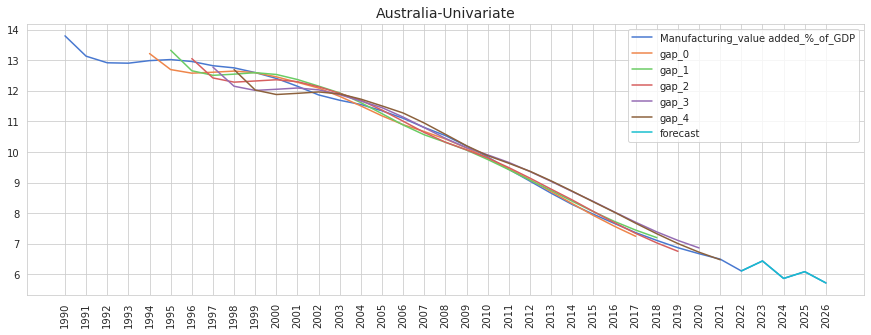

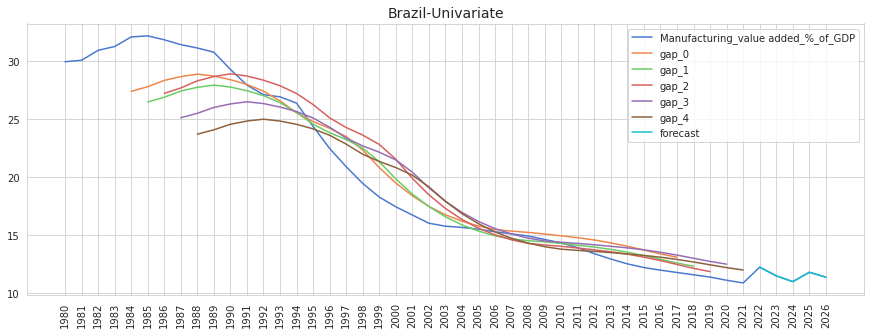

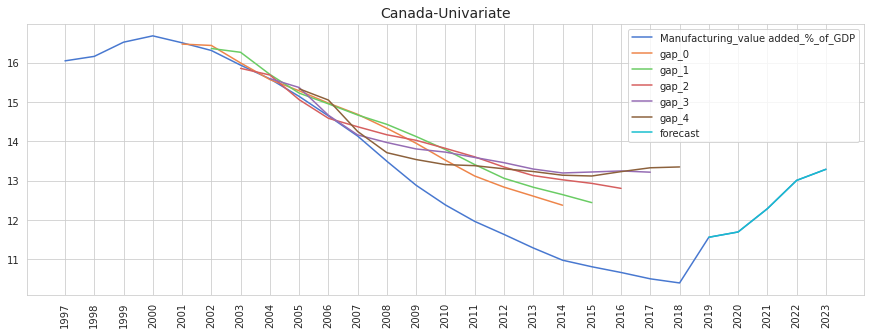

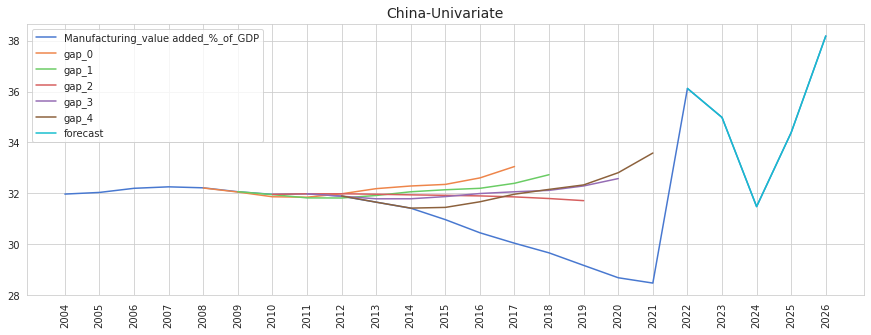

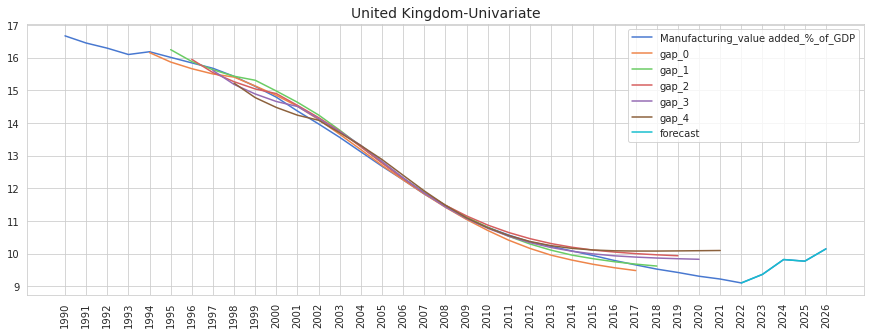

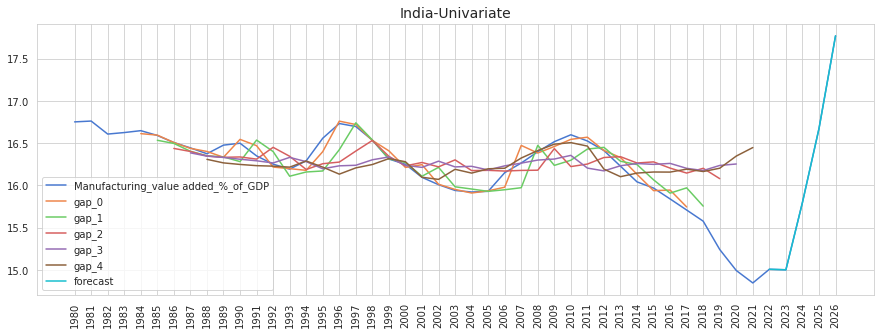

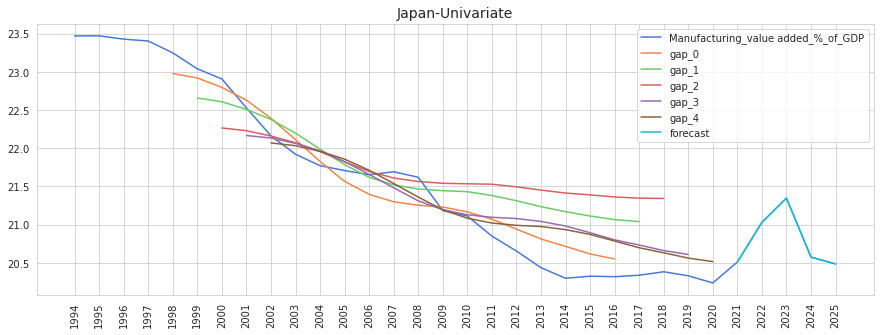

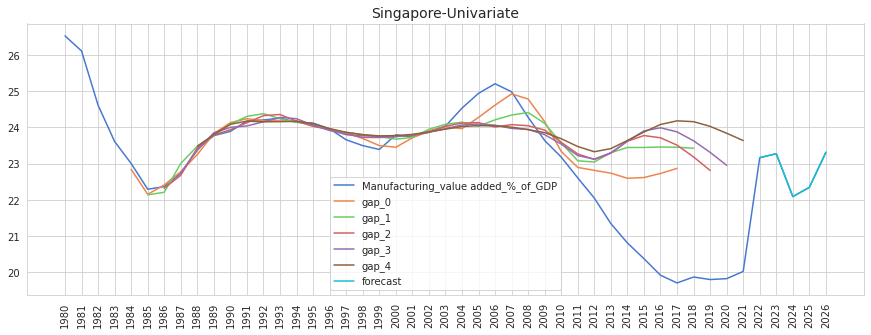

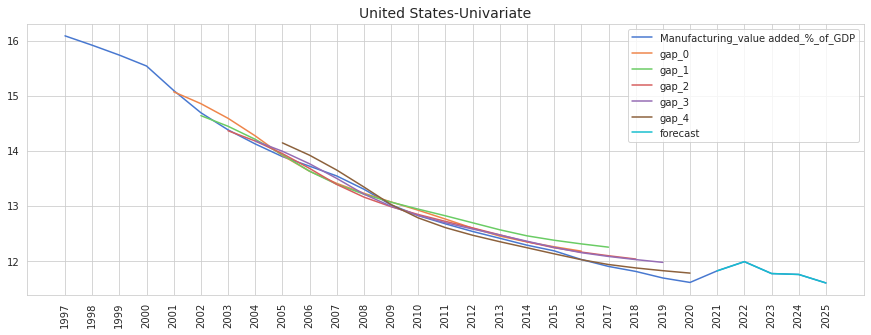

In [78]:
for ckey in m_dfs.keys():
  country = dic_country[ckey]
  data = m_dfs[ckey]
  data = data[['Manufacturing_value added_%_of_GDP']]
  rbscaler = MRobustScaler() 
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  # use 4 year to predict 1 year ahead
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1],
  '\nMAPE', list(MAPE(y_pred, y_real)), 'Mean RMSE', MAPE(y_pred, y_real)[1],
  )
  MAEs.append(str(round(min(MAE(y_pred, y_real)[0]), 2)) + '-' + str(round(max(MAE(y_pred, y_real)[0]),2)))
  RMSEs.append(str(round(min(RMSE(y_pred, y_real)[0]), 2)) + '-' + str(round(max(RMSE(y_pred, y_real)[0]),2)))
  MAPEs.append(str(round(min(MAPE(y_pred, y_real)), 2)) + '-' + str(round(max(MAPE(y_pred, y_real)),2)))
  y_pred, y_real = fetch_all_pred_real(rbscaler, model)
  fcst = forecast(rbscaler, scaled_data, model, IW=IW)
  fcst['forecast'] = fcst['Manufacturing_value added_%_of_GDP']
  df = pd.concat(
    [pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1),
    fcst
    ]
  )
  fig = plt.figure(figsize = (15, 5))
  ax = fig.add_subplot(1, 1, 1)
  ax = df.plot(color = cmap, ax=ax)
  plt.xticks(rotation=90)
  plt.title(f'{country}-{model_type}', fontsize=14)
  t = ax.set_xticks(list(df.index))
  ax.get_figure().savefig(output_path + target_type +f'/{country}-{model_type}', bbox_inches='tight')

In [1]:
rst = pd.DataFrame({
  'Country': [dic_country[c] for c in m_dfs.keys()]*2,
  'Type': ['Multivariate'] * 9 + ['Univariate'] * 9,
  'MAE': MAEs,
  'RMSE': RMSEs,
  'MAPE':MAPEs
              }).sort_values('Country').set_index('Country')
# rst.to_csv(result_path+target_type+'_result.csv')

##### 2-Service

In [43]:
SHIFT = 5
LW = 5
IW = 4
MAX_EPOCHS = 200
bs = 8
verbose = True
lr = 0.001
patience = 100
LOSS = tf.keras.losses.MeanAbsoluteError()

In [80]:
target_type = 'Service'

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1750 - val_loss: 0.3013
Epoch 2/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1131 - val_loss: 0.3016
Epoch 3/200
1/1 [==============================] - 0s 56ms/step - loss: 0.1020 - val_loss: 0.2971
Epoch 4/200
1/1 [==============================] - 0s 56ms/step - loss: 0.1091 - val_loss: 0.2871
Epoch 5/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0856 - val_loss: 0.2783
Epoch 6/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0738 - val_loss: 0.2735
Epoch 7/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0693 - val_loss: 0.2726
Epoch 8/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0730 - val_loss: 0.2711
Epoch 9/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0693 - val_loss: 0.2686
Epoch 10/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0628 - val_loss: 0.2654
Epoch 11/200
1/1 [===

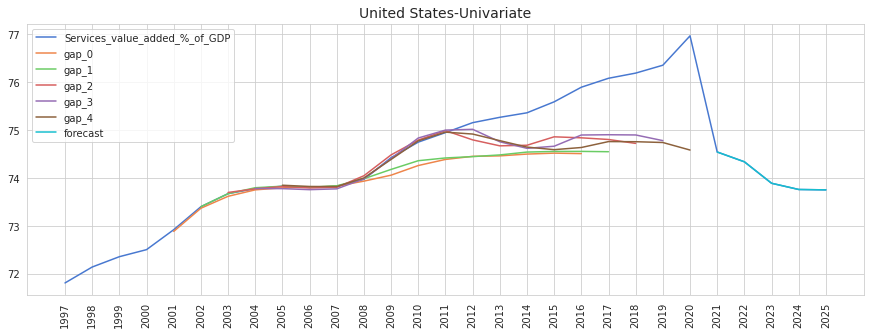

In [81]:
  country = dic_country[ckey]
  data = s_dfs[ckey]
  rbscaler = MRobustScaler() 
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  # use 4 year to predict 1 year ahead
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1],
  '\nMAPE', list(MAPE(y_pred, y_real)), 'Mean RMSE', MAPE(y_pred, y_real)[1],
  )
  MAEs.append(MAE(y_pred, y_real)[1])
  RMSEs.append(RMSE(y_pred, y_real)[1])
  MAPEs.append(MAPE(y_pred, y_real)[1])
  y_pred, y_real = fetch_all_pred_real(rbscaler, model)
  fcst = forecast(rbscaler, scaled_data, model, name = 'Services_value_added_%_of_GDP', IW=IW)
  fcst['forecast'] = fcst['Services_value_added_%_of_GDP']
  df = pd.concat(
    [pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1),
    fcst
    ]
  )
  fig = plt.figure(figsize = (15, 5))
  ax = fig.add_subplot(1, 1, 1)
  ax = df.plot(color = cmap, ax=ax)
  plt.xticks(rotation=90)
  plt.title(f'{country}-{model_type}', fontsize=14)
  t = ax.set_xticks(list(df.index))
  ax.get_figure().savefig(output_path + target_type +f'/{country}-{model_type}', bbox_inches='tight')

###### Multivariate

In [82]:
model_type = 'Multivariate'

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1937 - val_loss: 0.1845
Epoch 2/200
1/1 [==============================] - 0s 54ms/step - loss: 0.1417 - val_loss: 0.1733
Epoch 3/200
1/1 [==============================] - 0s 61ms/step - loss: 0.1170 - val_loss: 0.1622
Epoch 4/200
1/1 [==============================] - 0s 65ms/step - loss: 0.1072 - val_loss: 0.1524
Epoch 5/200
1/1 [==============================] - 0s 60ms/step - loss: 0.1052 - val_loss: 0.1482
Epoch 6/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0844 - val_loss: 0.1456
Epoch 7/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0649 - val_loss: 0.1416
Epoch 8/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0498 - val_loss: 0.1377
Epoch 9/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0481 - val_loss: 0.1308
Epoch 10/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0366 - val_loss: 0.1224
Epoch 11/200
1/1 [===

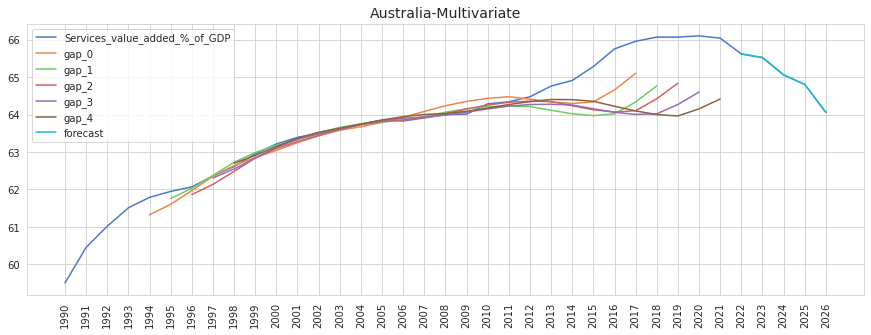

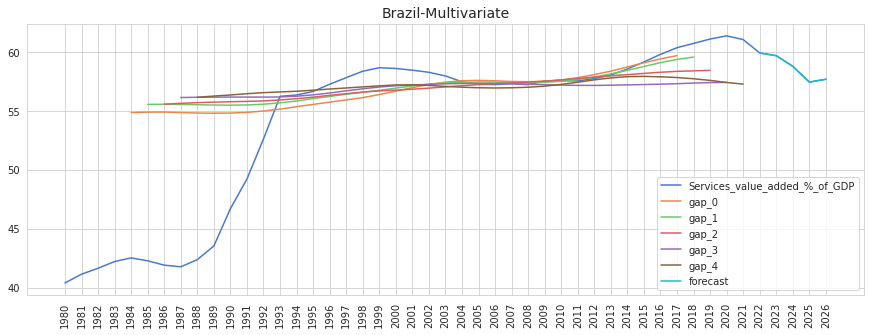

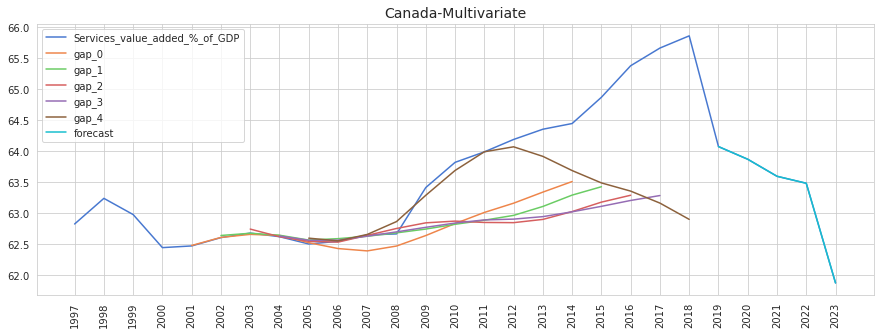

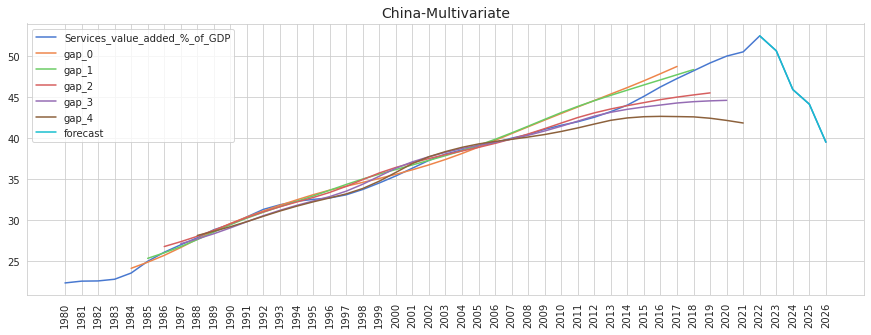

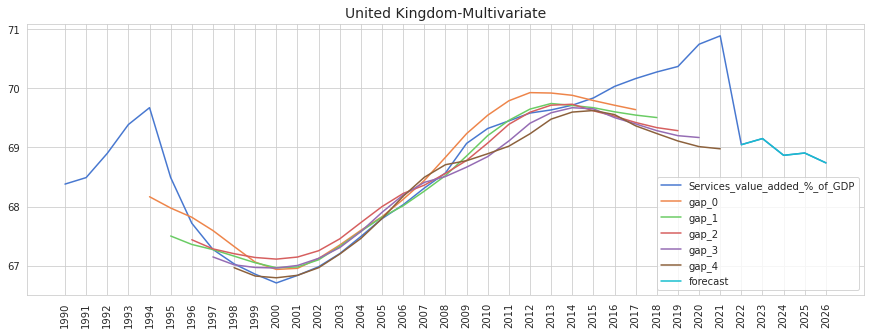

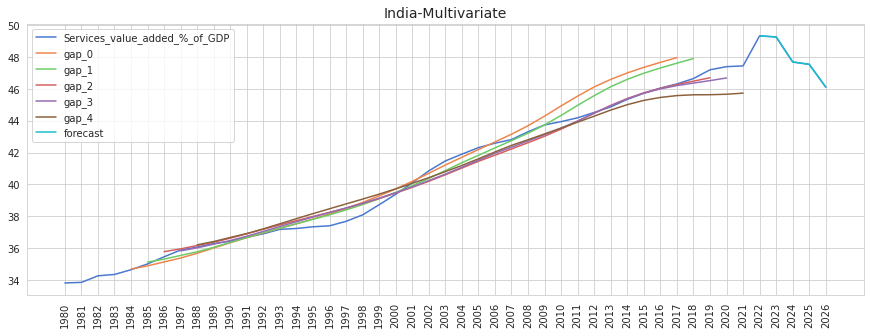

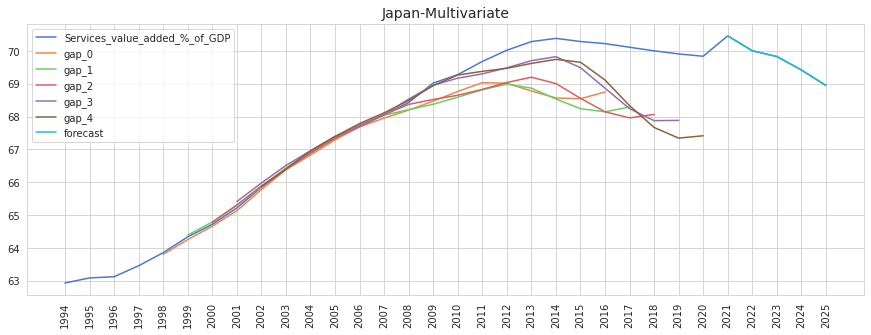

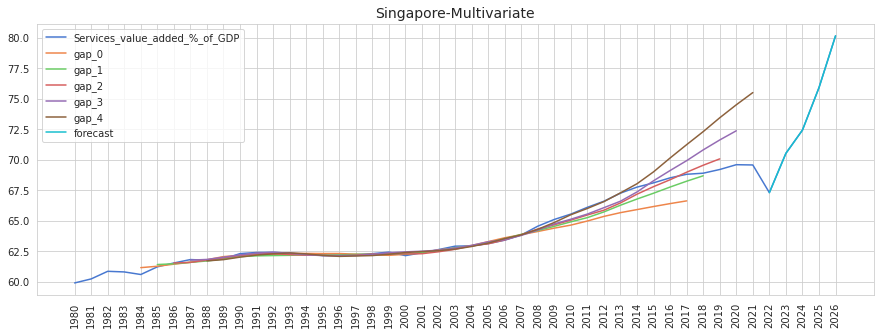

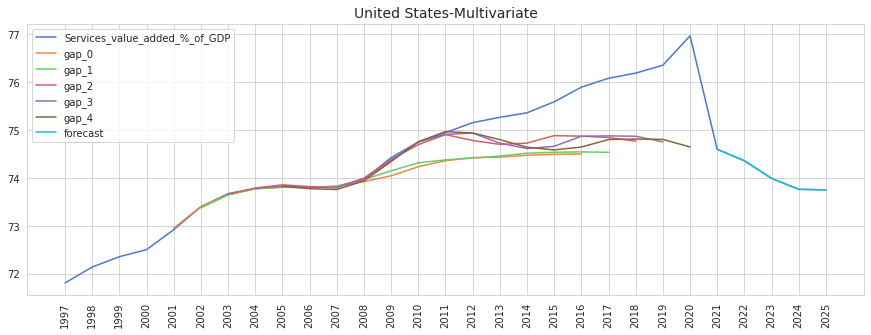

In [83]:
MAEs, RMSEs, MAPEs = [], [], []
for ckey in s_dfs.keys():
  country = dic_country[ckey]
  data = s_dfs[ckey]
  rbscaler = MRobustScaler() 
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  # use 4 year to predict 1 year ahead
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1],
  '\nMAPE', list(MAPE(y_pred, y_real)), 'Mean RMSE', MAPE(y_pred, y_real)[1],
  )
  MAEs.append(str(round(min(MAE(y_pred, y_real)[0]), 2)) + '-' + str(round(max(MAE(y_pred, y_real)[0]),2)))
  RMSEs.append(str(round(min(RMSE(y_pred, y_real)[0]), 2)) + '-' + str(round(max(RMSE(y_pred, y_real)[0]),2)))
  MAPEs.append(str(round(min(MAPE(y_pred, y_real)), 2)) + '-' + str(round(max(MAPE(y_pred, y_real)),2)))
  y_pred, y_real = fetch_all_pred_real(rbscaler, model)
  fcst = forecast(rbscaler, scaled_data, model, name = 'Services_value_added_%_of_GDP', IW=IW)
  fcst['forecast'] = fcst['Services_value_added_%_of_GDP']
  df = pd.concat(
    [pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1),
    fcst
    ]
  )
  fig = plt.figure(figsize = (15, 5))
  ax = fig.add_subplot(1, 1, 1)
  ax = df.plot(color = cmap, ax=ax)
  plt.xticks(rotation=90)
  plt.title(f'{country}-{model_type}', fontsize=14)
  t = ax.set_xticks(list(df.index))
  ax.get_figure().savefig(output_path + target_type +f'/{country}-{model_type}', bbox_inches='tight')

###### Univariate

In [84]:
model_type = 'Univariate'

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1895 - val_loss: 0.2024
Epoch 2/200
1/1 [==============================] - 0s 49ms/step - loss: 0.1620 - val_loss: 0.2116
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 0.1361 - val_loss: 0.2222
Epoch 4/200
1/1 [==============================] - 0s 47ms/step - loss: 0.1116 - val_loss: 0.2317
Epoch 5/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0950 - val_loss: 0.2354
Epoch 6/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0898 - val_loss: 0.2252
Epoch 7/200
1/1 [==============================] - 0s 51ms/step - loss: 0.0972 - val_loss: 0.2070
Epoch 8/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0777 - val_loss: 0.1882
Epoch 9/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0691 - val_loss: 0.1706
Epoch 10/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0689 - val_loss: 0.1538
Epoch 11/200
1/1 [===

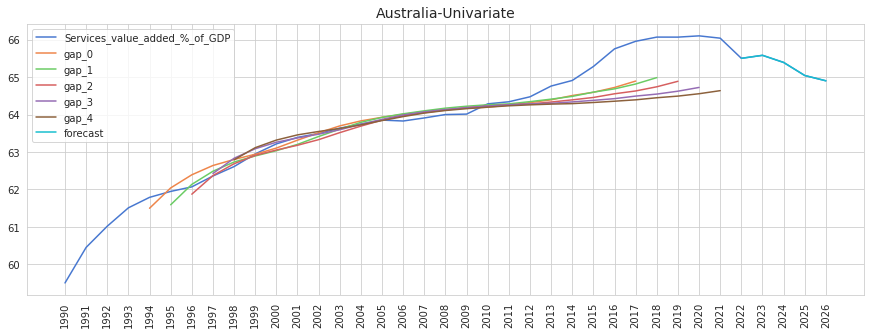

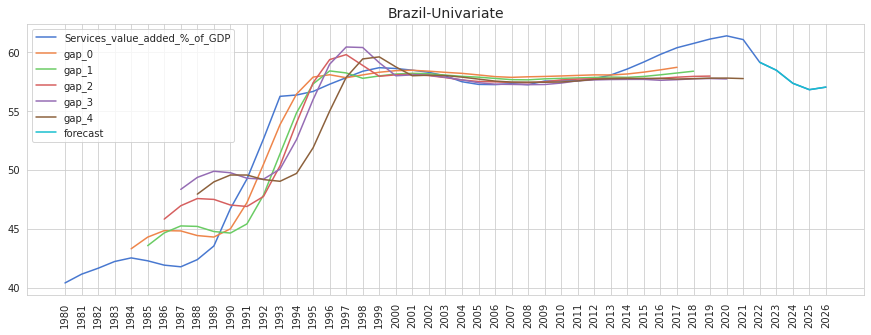

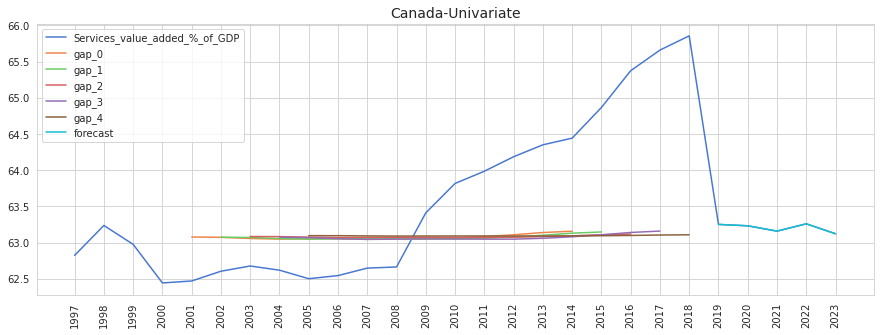

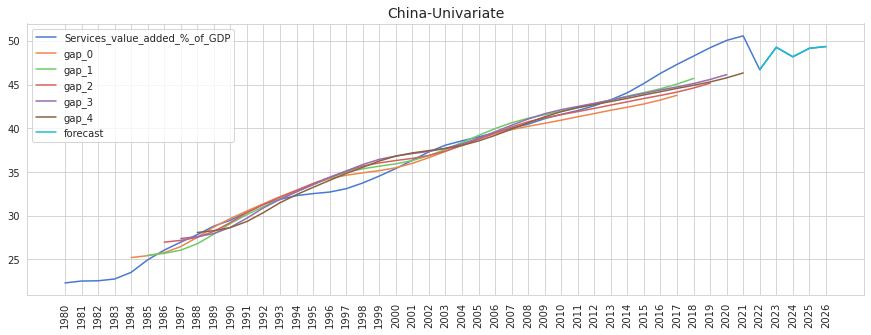

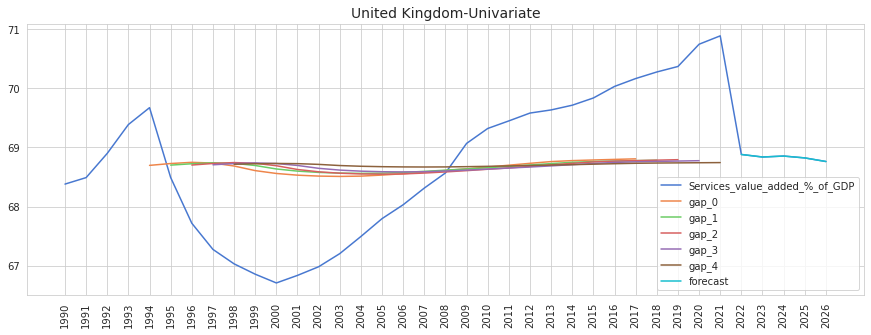

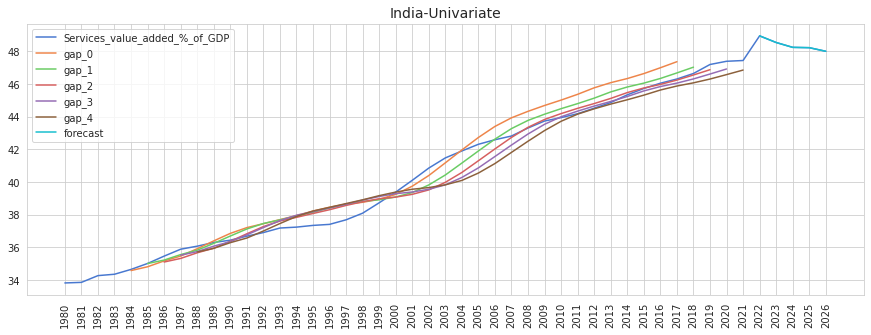

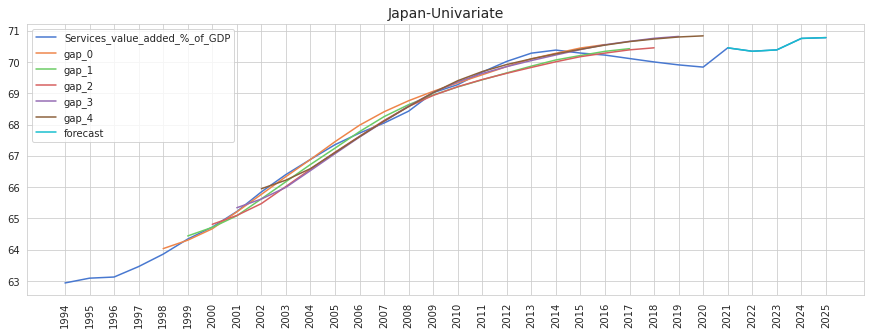

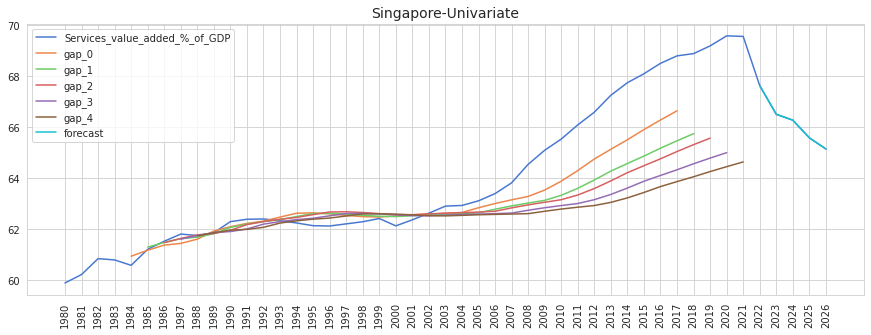

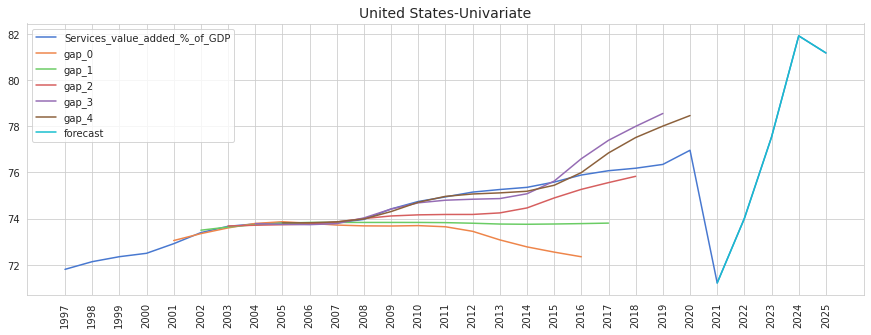

In [85]:
for ckey in s_dfs.keys():
  country = dic_country[ckey]
  data = s_dfs[ckey]
  data = data[['Services_value_added_%_of_GDP']]
  rbscaler = MRobustScaler() 
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  # use 4 year to predict 1 year ahead
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1],
  '\nMAPE', list(MAPE(y_pred, y_real)), 'Mean RMSE', MAPE(y_pred, y_real)[1],
  )
  MAEs.append(str(round(min(MAE(y_pred, y_real)[0]), 2)) + '-' + str(round(max(MAE(y_pred, y_real)[0]),2)))
  RMSEs.append(str(round(min(RMSE(y_pred, y_real)[0]), 2)) + '-' + str(round(max(RMSE(y_pred, y_real)[0]),2)))
  MAPEs.append(str(round(min(MAPE(y_pred, y_real)), 2)) + '-' + str(round(max(MAPE(y_pred, y_real)),2)))
  y_pred, y_real = fetch_all_pred_real(rbscaler, model)
  fcst = forecast(rbscaler, scaled_data, model, name = 'Services_value_added_%_of_GDP', IW=IW)
  fcst['forecast'] = fcst['Services_value_added_%_of_GDP']
  df = pd.concat(
    [pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1),
    fcst
    ]
  )
  fig = plt.figure(figsize = (15, 5))
  ax = fig.add_subplot(1, 1, 1)
  ax = df.plot(color = cmap, ax=ax)
  plt.xticks(rotation=90)
  plt.title(f'{country}-{model_type}', fontsize=14)
  t = ax.set_xticks(list(df.index))
  ax.get_figure().savefig(output_path + target_type +f'/{country}-{model_type}', bbox_inches='tight')

In [86]:
rst = pd.DataFrame({
  'Country': [dic_country[c] for c in s_dfs.keys()]*2,
  'Type': ['Multivariate'] * 9 + ['Univariate'] * 9,
  'MAE': MAEs,
  'RMSE': RMSEs,
  'MAPE':MAPEs
              }).sort_values('Country').set_index('Country')
# rst.to_csv(result_path+target_type+'_result.csv')
rst

,Type,MAE,RMSE,MAPE
Country,,,,
Australia,Multivariate,0.67-1.86,0.75-1.87,0.01-0.03
Australia,Univariate,0.62-1.52,0.71-1.52,0.01-0.02
Brazil,Multivariate,0.33-3.12,0.38-3.2,0.01-0.05
Brazil,Univariate,0.76-2.99,0.96-3.03,0.01-0.05
Canada,Multivariate,0.95-1.74,0.96-1.9,0.01-0.03
Canada,Univariate,0.93-1.99,0.98-2.07,0.01-0.03
China,Multivariate,1.12-6.2,1.31-6.45,0.03-0.13
China,Univariate,1.34-3.44,1.63-3.53,0.03-0.07
India,Multivariate,0.13-1.65,0.22-1.65,0.0-0.04
